If you are executing from Google Colab please execute this cell

In [1]:
!pip install fastai==2.5.2

Importing necessary libraries

In [2]:
from fastai.vision.all import *

Loading the functions needed to load the learner without errors

In [3]:
def label_func(fname):
    return str(fname).split('/')[-2]

def ParentSplitter(x):
    return Path(x).parent.parent.name=='val'

class CropTransform(RandTransform):
    split_idx= None
    def __init__(self): 
        super().__init__()
    def encodes(self, x: Image.Image):
        return x.crop((634, 0, 3206, 2160))

We load the learner into CPU, be sure to have selected the right kernel in Google Colab

In [4]:
learn = load_learner('detection-learner.pkl', cpu=False)

We define the functions neccesary for Grad Cam. This is based on [this notebook](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb) from FastAI book.

In [5]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
    
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [6]:
def get_detection_map(path, ratio=0.6):
    img = PILImage.create(path)
    x, = first(learn.dls.test_dl([img]))
    x_dec = TensorImage(learn.dls.train.decode((x,))[0][0])
    im_size = x_dec.shape[1]


    prediction = learn.predict(path)
    cls = prediction[1].numpy()
    with HookBwd(learn.model[0]) as hookg:
        with Hook(learn.model[0]) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0,cls].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    binary_cam=cam_map>ratio*cam_map.max()

    _,ax = plt.subplots(figsize=(10,10))
    x_dec.show(ctx=ax)
    ax.imshow(binary_cam.detach().cpu(), alpha=0.4, extent=(0,im_size,im_size,0),
                  interpolation='bilinear', cmap='magma');
    print('Class: '+prediction[0])

# Inference

We test the model on some images

/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-eoxszjt0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Class: fauna


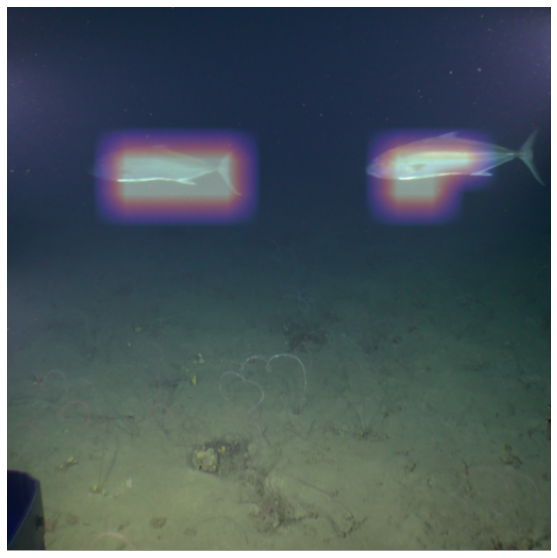

In [6]:
get_detection_map('split_ocean_elements/val/fauna/12fae6ae4a7c85946bc7f579752426cf.jpg',0.55)

Class: algas


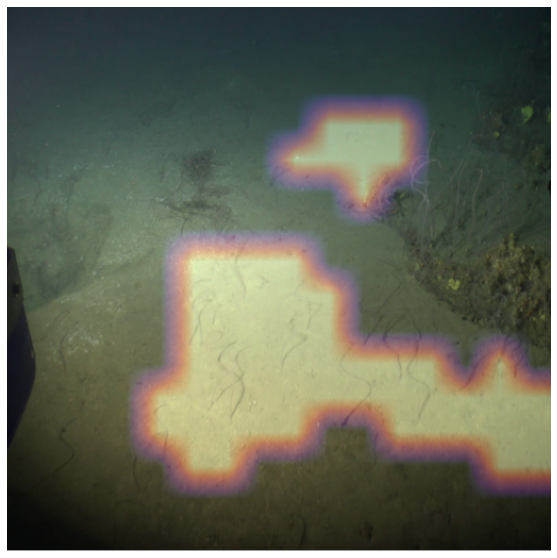

In [7]:
get_detection_map('split_ocean_elements/train/algas/e2412d58cb22d45284b639e5cf578aaa.jpg', 0.3)

Class: basura


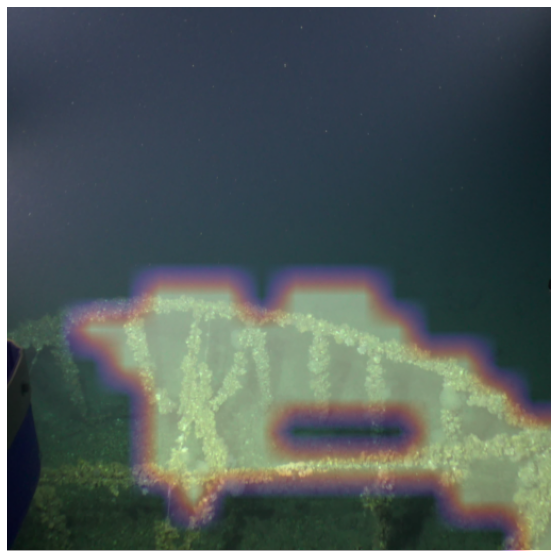

In [8]:
get_detection_map('split_ocean_elements/val/basura/1b5031c7cd96508c5c9005ace4a3566c.jpg', 0.47)

Class: roca


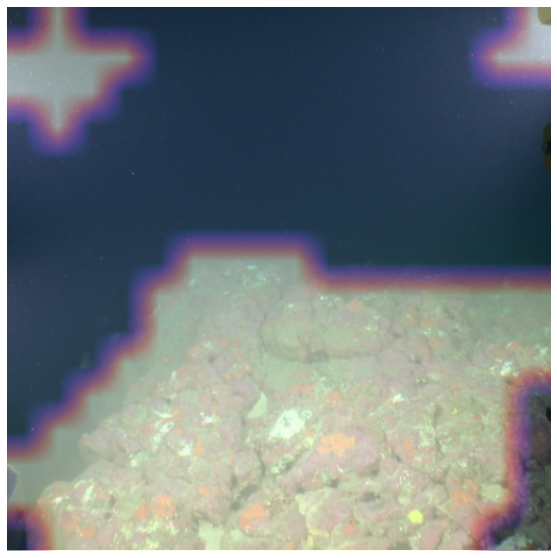

In [9]:
get_detection_map('split_ocean_elements/val/roca/d67f38be360d78674ec840e1f6fe6b78.jpg', 0.4)

Class: basura


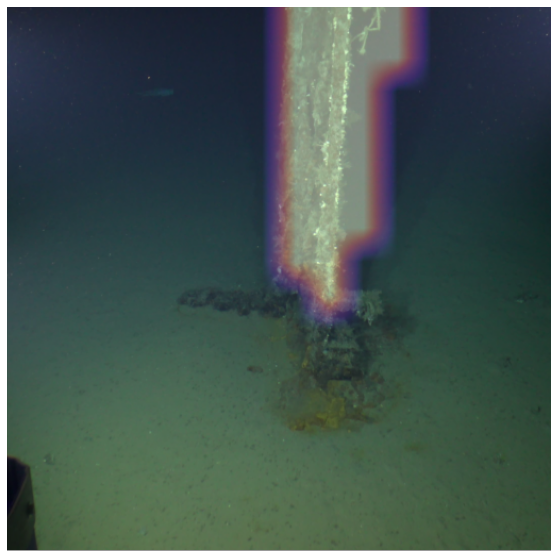

In [10]:
get_detection_map('split_ocean_elements/val/basura/3a56c822bcd90d10b7ec6aefe3a481aa.jpg', 0.5)

Class: basura


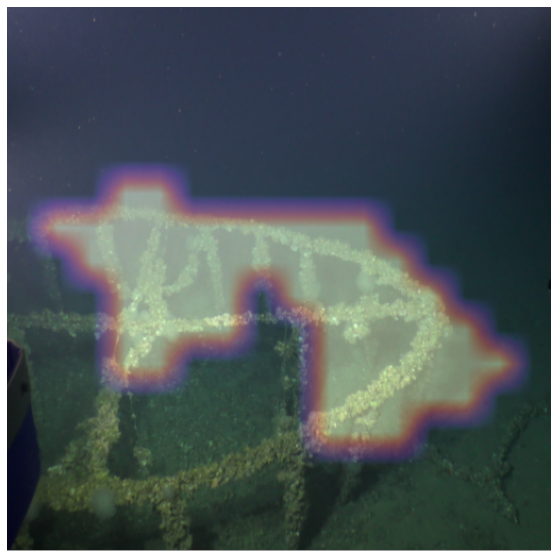

In [11]:
get_detection_map('split_ocean_elements/val/basura/e519888b8c75e826d2e6f201ff90b80c.jpg', 0.55)

Class: fauna


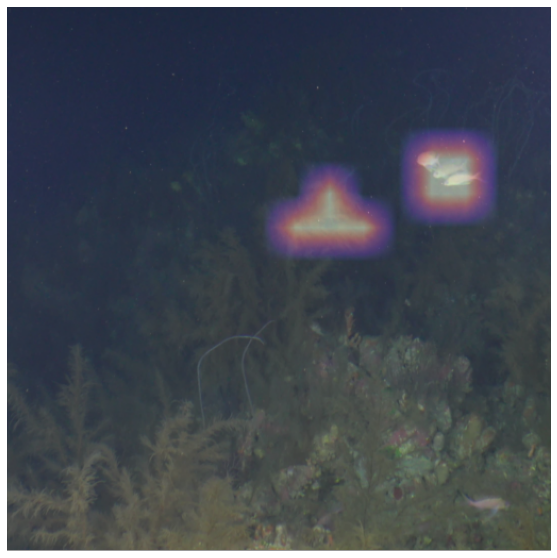

In [12]:
get_detection_map('split_ocean_elements/val/fauna/e93bb9fe671cb8ba7b23bed5a895f4e5.jpg', ratio=0.9)

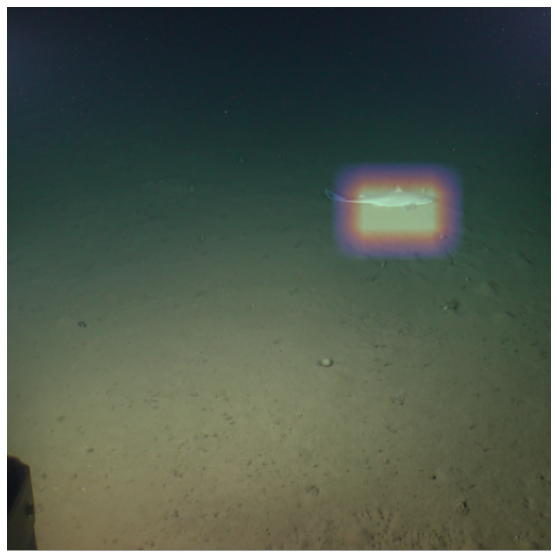

In [15]:
get_detection_map('split_ocean_elements/val/fauna/9423adb18ee19edd4cdaf9d080d7b766.jpg', ratio=0.7)

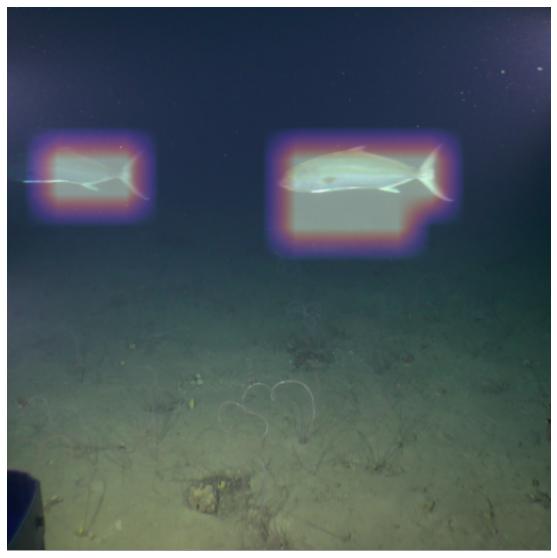

In [25]:
get_detection_map('split_ocean_elements/train/fauna/b8e4d6291b3b7d82c13d466ed0e12026.jpg', ratio=0.5)